「RとStanで始めるベイズ統計モデリングによるデータ分析入門」「実践編第3部第10章 交互作用：カテゴリ×カテゴリ」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。

本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです。

# 分析の準備

## パッケージの読み込み

In [1]:
import arviz
import pystan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'
import seaborn as sns

# カテゴリ×カテゴリ：モデル化
## 分析対象のデータ

In [2]:
interaction_1 = pd.read_csv('3-10-1-interaction-1.csv')
interaction_1.head(n=3)
interaction_1

,sales,publicity,bargen
0,87.5,not,not
1,103.7,not,not
2,83.3,not,not
3,131.9,not,not
4,106.6,not,not
...,...,...,...
95,171.2,to_implement,to_implement
96,134.5,to_implement,to_implement
97,148.5,to_implement,to_implement
98,135.5,to_implement,to_implement


## データの要約

In [3]:
interaction_1.describe(include='all')

,sales,publicity,bargen
count,100.00000,100,100
unique,NaN,2,2
top,NaN,to_implement,to_implement
freq,NaN,50,50
mean,127.17900,NaN,NaN
std,28.48545,NaN,NaN
min,55.70000,NaN,NaN
25%,108.85000,NaN,NaN
50%,124.35000,NaN,NaN
75%,148.52500,NaN,NaN


## デザイン行列の作成

In [4]:
# ダミー変数化処理
design_mat = pd.get_dummies(interaction_1.drop(['sales'], axis=1),
                            drop_first=True)

# 交互作用項の追加
design_mat['publicity_to_implement:bargen_to_implement'] = design_mat[
    'publicity_to_implement'] * design_mat['bargen_to_implement']

# (Intercept)列追加
design_mat.insert(0, '(Intercept)', 1)

display(design_mat)

,(Intercept),publicity_to_implement,bargen_to_implement,publicity_to_implement:bargen_to_implement
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
95,1,1,1,1
96,1,1,1,1
97,1,1,1,1
98,1,1,1,1


## 参考：デザイン行列を用いない方法

### dictにまとめる

In [5]:
data_dict = dict(N=len(interaction_1),
                 sales=interaction_1['sales'],
                 publicity=design_mat['publicity_to_implement'],
                 bargen=design_mat['bargen_to_implement'],
                 publicity_bargen=design_mat['publicity_to_implement:bargen_to_implement'])

### dictの表示

In [6]:
display(data_dict)

{'N': 100,
 'sales': 0      87.5
 1     103.7
 2      83.3
 3     131.9
 4     106.6
       ...  
 95    171.2
 96    134.5
 97    148.5
 98    135.5
 99    150.5
 Name: sales, Length: 100, dtype: float64,
 'publicity': 0     0
 1     0
 2     0
 3     0
 4     0
      ..
 95    1
 96    1
 97    1
 98    1
 99    1
 Name: publicity_to_implement, Length: 100, dtype: uint8,
 'bargen': 0     0
 1     0
 2     0
 3     0
 4     0
      ..
 95    1
 96    1
 97    1
 98    1
 99    1
 Name: bargen_to_implement, Length: 100, dtype: uint8,
 'publicity_bargen': 0     0
 1     0
 2     0
 3     0
 4     0
      ..
 95    1
 96    1
 97    1
 98    1
 99    1
 Name: publicity_to_implement:bargen_to_implement, Length: 100, dtype: uint8}

### MCMCの実行

In [7]:
# stanコードの記述
stan_code = '''
data {
    int N;
    vector[N] sales;
    vector[N] publicity;
    vector[N] bargen;
    vector[N] publicity_bargen;
}

parameters {
    real Intercept;
    real b_publicity;
    real b_bargen;
    real b_publicity_bargen;
    real<lower=0> sigma;
}

model {
    vector[N] mu = Intercept + b_publicity*publicity + b_bargen*bargen + b_publicity_bargen*publicity_bargen;
    sales ~ normal(mu, sigma);
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
interaction_stan_1 = stan_model.sampling(data=data_dict, seed=2, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0b6d991038d081bcb57dd2122b42571b NOW.


### MCMCの結果の確認

In [8]:
print(interaction_stan_1.stansummary(probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_0b6d991038d081bcb57dd2122b42571b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
Intercept          103.32    0.08   3.75  95.72 103.41 110.42   2108    1.0
b_publicity           9.9    0.12   5.21   0.06   9.71  20.58   2021    1.0
b_bargen            27.33    0.12   5.33  17.07  27.26   38.1   1978    1.0
b_publicity_bargen  20.79    0.17   7.52   6.05  20.78  35.32   2012    1.0
sigma               18.41    0.03   1.34  15.99  18.31  21.26   2436    1.0
lp__               -337.8    0.04   1.66 -341.8 -337.5 -335.6   1457    1.0

Samples were drawn using NUTS at Mon Sep  7 19:07:29 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### 参考：事後分布の図示

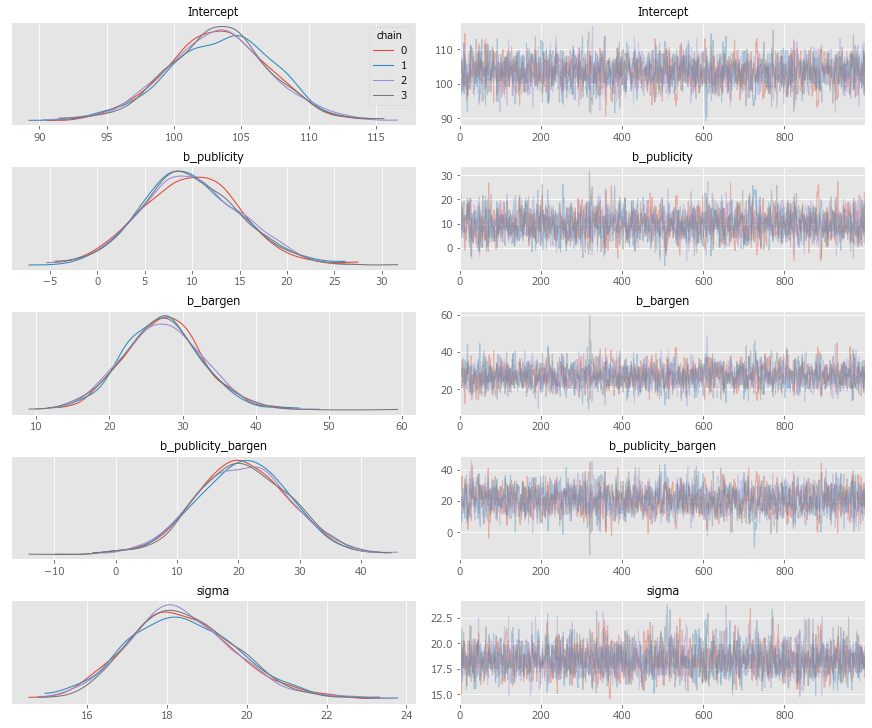

In [9]:
arviz.plot_trace(interaction_stan_1,
                 var_names=['Intercept', 'b_publicity', 'b_bargen', 'b_publicity_bargen', 'sigma'],
                 legend=True);

## 参考：デザイン行列を用いる方法

### Stanに渡すdictの作成

In [10]:
data_dict = dict(N=len(interaction_1),
                 K=design_mat.shape[1],
                 Y=interaction_1['sales'],
                 X=design_mat)

In [11]:
display(data_dict)

{'N': 100,
 'K': 4,
 'Y': 0      87.5
 1     103.7
 2      83.3
 3     131.9
 4     106.6
       ...  
 95    171.2
 96    134.5
 97    148.5
 98    135.5
 99    150.5
 Name: sales, Length: 100, dtype: float64,
 'X':     (Intercept)  publicity_to_implement  bargen_to_implement  \
 0             1                       0                    0   
 1             1                       0                    0   
 2             1                       0                    0   
 3             1                       0                    0   
 4             1                       0                    0   
 ..          ...                     ...                  ...   
 95            1                       1                    1   
 96            1                       1                    1   
 97            1                       1                    1   
 98            1                       1                    1   
 99            1                       1                    1   
 
  

### MCMCの実行

In [12]:
# stanコードの記述
stan_code = '''
data { 
  int N;                // サンプルサイズ
  int K;                // デザイン行列の列数(説明変数の数＋１)
  vector[N] Y;          // 応答変数 
  matrix[N, K] X;       // デザイン行列 
} 

parameters { 
  vector[K] b;          // 切片を含む係数ベクトル
  real<lower=0> sigma;  // データのばらつきを表す標準偏差
} 

model { 
  vector[N] mu = X * b;
  Y ~ normal(mu, sigma);
} 

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
interaction_stan_design_1 = stan_model.sampling(data=data_dict, seed=1, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ff3814f23c22278ffe4dee1df56226cc NOW.


### MCMCの結果の確認

In [13]:
print(interaction_stan_design_1.stansummary(probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_ff3814f23c22278ffe4dee1df56226cc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
b[1]  103.32    0.09   3.72  95.75 103.44 110.34   1841    1.0
b[2]   10.03    0.13   5.29  -0.19   9.92  20.62   1733    1.0
b[3]    27.3    0.12   5.27  17.04  27.19  37.85   1799    1.0
b[4]   20.71    0.19   7.57   5.88   20.7  35.16   1670    1.0
sigma  18.48    0.03    1.4  16.04  18.36  21.54   2368    1.0
lp__  -337.8    0.04   1.68 -341.9 -337.5 -335.6   1505    1.0

Samples were drawn using NUTS at Mon Sep  7 19:08:14 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### 参考：事後分布の図示

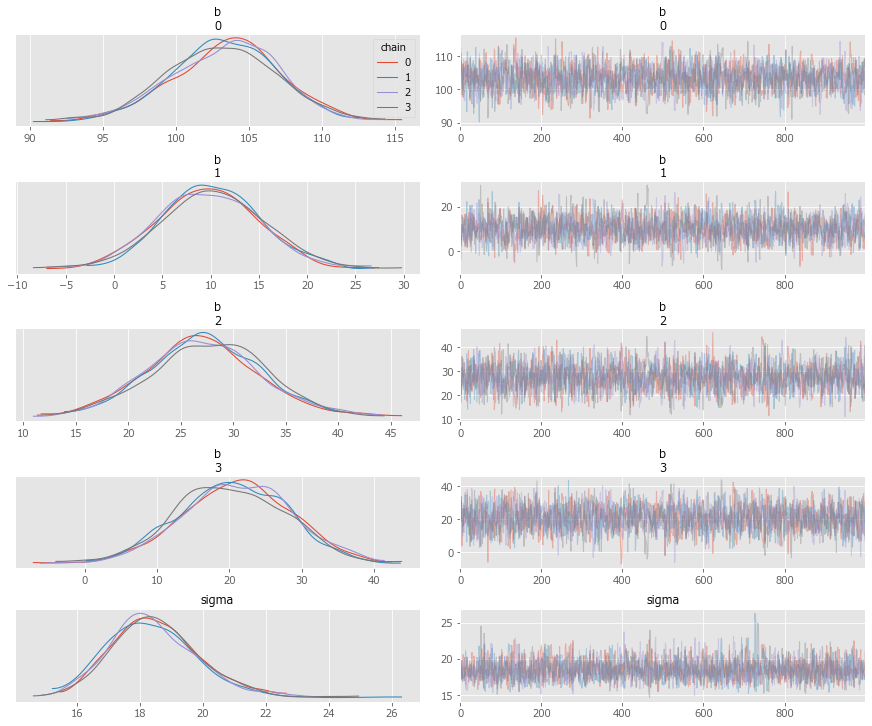

In [14]:
arviz.plot_trace(interaction_stan_design_1,
                 var_names=['b', 'sigma'],
                 legend=True);

# カテゴリ×カテゴリ：係数の解釈

## 交互作用の効果の確認

### 説明変数を作る

In [15]:
newdata_1 = np.matrix([[1, 0, 0, 0],  # 宣伝なし＋安売りなし
                       [1, 1, 0, 0],  # 宣伝あり＋安売りなし
                       [1, 0, 1, 0],  # 宣伝なし＋安売りあり
                       [1, 1, 1, 1]]) # 宣伝あり＋安売りあり

### 補足：係数行列を作る

In [16]:
# MCMCサンプルの抽出
mcmc_sample = interaction_stan_1.extract()

# 係数行列を作る
newdata_1_b = np.matrix([mcmc_sample['Intercept'],
                         mcmc_sample['b_publicity'],
                         mcmc_sample['b_bargen'],
                         mcmc_sample['b_publicity_bargen']])

### 予測

In [17]:
display(pd.DataFrame((newdata_1* newdata_1_b).T, 
                     columns=('宣伝なし安売りなし',
                              '宣伝あり安売りなし',
                              '宣伝なし安売りあり',
                              '宣伝あり安売りあり')).describe())

,宣伝なし安売りなし,宣伝あり安売りなし,宣伝なし安売りあり,宣伝あり安売りあり
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,103.323032,113.225434,130.649403,161.337930
std,3.750065,3.734543,3.725319,3.761157
min,89.246544,98.129091,117.011108,146.542548
25%,100.845075,110.734032,128.194983,158.774321
50%,103.405504,113.148715,130.664441,161.355668
75%,105.810812,115.668267,133.068575,163.937452
max,116.578397,129.632881,151.903404,174.095731


# カテゴリ×カテゴリ：モデルの図示

## 参考：表示対象のデータ

In [18]:
# 予測結果のデータフレームの作成
prediction = pd.DataFrame({
    'sales': np.ravel(newdata_1 * newdata_1_b), # 1次元配列化した予測結果
    'publicity': 'not', # 初期値はすべて宣伝なし
    'bargen': 'not'     # 初期値はすべて安売りなし
})

# データフレームの内容の修正
# 説明変数（newdata_1）の内容に従い宣伝＋安売りの有無を変更する

# 4000:8000行の宣伝の有無を宣伝あり（to_implement)に変更
prediction['publicity'][4000:8000] = 'to_implement'
# 12000:16000行の宣伝の有無を宣伝ありに変更
prediction['publicity'][12000:16000] = 'to_implement'
# 8000:16000行の安売りの有無を安売りありに変更
prediction['bargen'][8000:16000] = 'to_implement'

C:\Users\rhira\Anaconda3\envs\multi\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\rhira\Anaconda3\envs\multi\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\rhira\Anaconda3\envs\multi\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


## モデルの図示

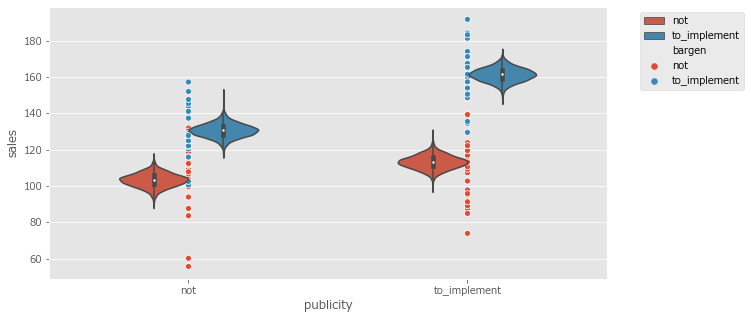

In [21]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='publicity', y='sales', hue='bargen', data=interaction_1)
sns.violinplot(x='publicity',
               y='sales',
               hue='bargen',
               data=prediction,
               showfliers=False,
               width=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()